## Description

Pedestals capture is a way of capturing the biases of each sample cell of the board, to zero out the ADC counts, which results in a more accurate signal reading. The pedestals controller is the main method of capturing and creating pedestals data which is stored to the board and used for pedestals correction.

### Naludaq Version
*Max Version*: `0.17.2`  
*Min Version*: `0.17.2`

In [1]:
# Print Naludaq version
import naludaq
print(f"Naludaq version: {naludaq.__version__}")

Naludaq version: 0.31.3


### Compatible Boards
+ All boards

In [2]:
from naludaq.board import Board, startup_board
from naludaq.tools.pedestals import get_pedestals_controller

### Create board

If an external server is used, skip the `BOARD.start_server()`.

In [3]:
MODEL = "hdsocv2_eval"
# SERVER_ADDR = ("127.0.0.1", 7878)  # Only when using external server
RECV_ADDR = ("192.168.1.165", 0x1234)
BRD_ADDR = ("192.168.1.60", 0x1234)

In [ ]:
BOARD = Board(MODEL)

# Comment out the next line if the stand-alone daq server is used.
BOARD.start_server(output_dir=".")
BOARD.connect_udp(receiver_addr=RECV_ADDR, board_addr=BRD_ADDR)
startup_board(BOARD)

### Generate pedestals
Generated pedestals will be stored under BOARD.pedestals together with the raw data used to build the pedestals.\
Pedestals is stored as a numpy array with the following structure:  
`BOARD.pedestals['data'][channel, window_number, sample_in_window]`

When generating pedestals it can be beneficial to capture "warmup" events to make sure the chip is at operating temperature.\
This is optional and depending on experiment.

In [8]:
peds_ctrl = get_pedestals_controller(BOARD)
peds_ctrl.generate_pedestals()

### Store pedestals in an acquisition

The pedestals are not automatically stored. To store the pedestals with the acquisition they have to be set manually.

Create a new acquisition in the server folder `output_dir`, then store the pedestals in the folder.


In [13]:
from naludaq.backend import AcquisitionManager
AM = AcquisitionManager(BOARD)

In [15]:
# Create an acquisition
ACQUISITION = AM.create()
ACQUISITION.pedestals = BOARD.pedestals

Created acquisition with name: 2024-10-22 08-03-55.216156
Available metadata keys: dict_keys(['params', 'registers'])


### To plot the pedestals, use the code below
The structure of the captured pedestals is designed for fast subtraction rather than plotting.
By reshaping the pedestals they can be plotted.

In [10]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

In [11]:
#reshape the data for easier plotting
_shape = BOARD.pedestals['data'].shape
_pedestals = BOARD.pedestals['data'].reshape(_shape[0], _shape[1]*_shape[2])

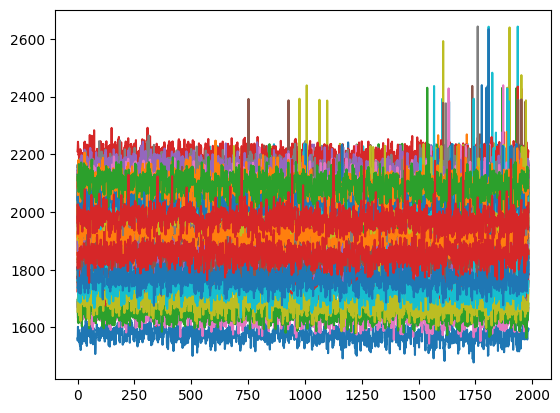

In [18]:
plt.plot(_pedestals.T)

### Advanced section
1. capture pedestals for a specific channel only
2. set warmup and datapoints per sample
3. plot pedestals for specific windows/channels
4. examine block capture times

#### 1. Capture specific channels

In [ ]:
peds_ctrl = get_pedestals_controller(BOARD, channels=[0,3])
peds_ctrl.generate_pedestals()

In [13]:
_shape = BOARD.pedestals['data'].shape
_pedestals = BOARD.pedestals['data'].reshape(_shape[0], _shape[1]*_shape[2])

for idx, ch in [(idx, d) for idx, d in enumerate(_pedestals) if not np.isnan(np.sum(d))]: # deactivated channels contains np.nan for all values
    plt.plot(ch, label=f'ch{idx}')
plt.legend()
plt.xlim(0,256)

#### 2. set the number of warmup events and datapoints per sample

In [20]:
peds_ctrl = get_pedestals_controller(BOARD, num_captures=5, num_warmup_events=5)
peds_ctrl.generate_pedestals()

#### 3. Plot a specific window or specific samples of the pedestal data

(0.0, 256.0)

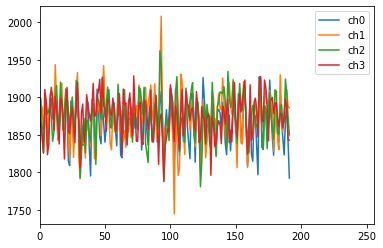

In [23]:
# Plot window 10,11,12
_shape = BOARD.pedestals['data'].shape
_pedestals = BOARD.pedestals['data'][:, 10:13, :].reshape(_shape[0], (13-10)*_shape[2])

for idx, ch in [(idx, d) for idx, d in enumerate(_pedestals) if not np.isnan(np.sum(d))]: # deactivated channels contains np.nan for all values
    plt.plot(ch, label=f'ch{idx}')
plt.legend()
plt.xlim(0,256)

(0.0, 50.0)

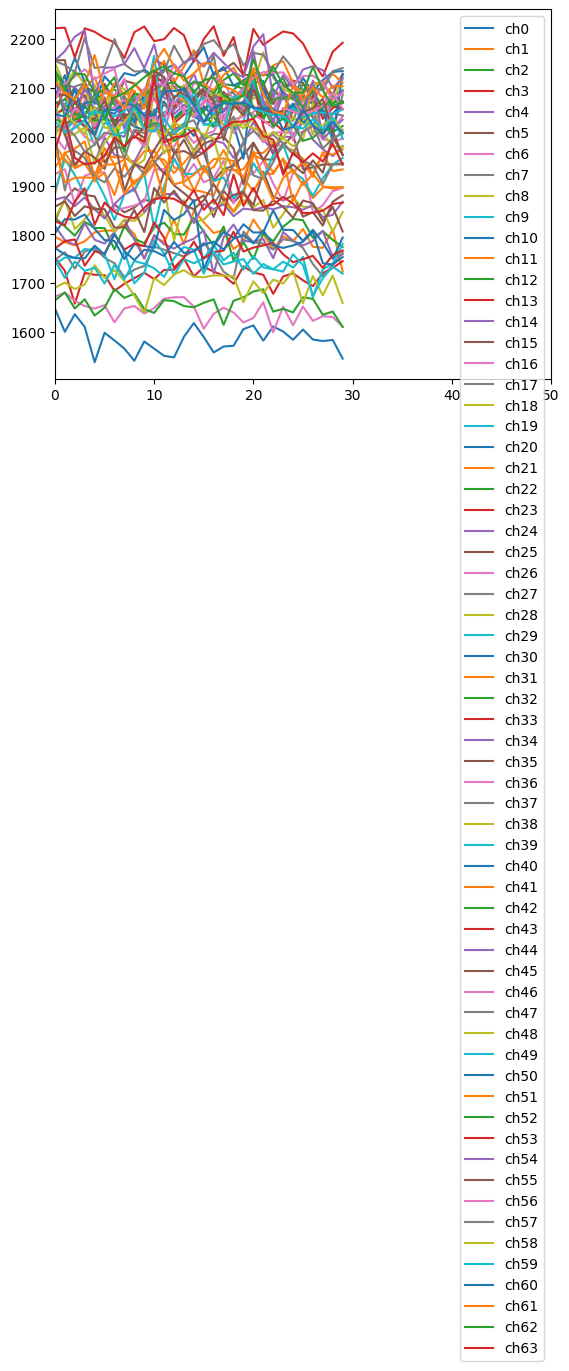

In [20]:
# Plot first 10 samples from window 10,11,12
_shape = BOARD.pedestals['data'].shape
_pedestals = BOARD.pedestals['data'][:, 10:13, :10].reshape(_shape[0], (13-10)*10)

for idx, ch in [(idx, d) for idx, d in enumerate(_pedestals) if not np.isnan(np.sum(d))]: # deactivated channels contains np.nan for all values
    plt.plot(ch, label=f'ch{idx}')
plt.legend()
plt.xlim(0,50)